In [2]:
import pandas as pd
from transform import *

In [3]:
totals, sig_strikes, fight_details = extract()

In [4]:
sig_strikes = transform_sig_stikes(sig_strikes)

In [5]:
fight_details['round'] = fight_details['round'].apply(lambda x: x.split(":")[1]).astype(int)
fight_details['last_round_secs'] = fight_details['time'].apply(lambda x: int(x.split(":")[1])*60 + int(x.split(":")[2]))
fight_details['fight_time'] = fight_details.apply(lambda x: (x['round'] -1)*300 + x['last_round_secs'], axis = 1)

In [6]:
strikes_by_fight = sig_strikes.groupby(['url','name']).sum().reset_index()
strikes_by_fight.head()

,url,name,body_strikes,body_attempts,ground_strikes,ground_attempts,head_strikes,head_attempts,leg_strikes,leg_attempts,distance_strikes,distance_attempts,clinch_strikes,clich_attempts
0,http://www.fightmetric.com/fight-details/000da...,Josh Neer,1,2,7,9,17,36,1,1,7,21,5,9
1,http://www.fightmetric.com/fight-details/000da...,Joshua Burkman,9,12,5,10,22,72,4,4,14,50,16,28
2,http://www.fightmetric.com/fight-details/0027e...,Jared Rosholt,3,4,10,17,19,41,0,0,9,24,3,4
3,http://www.fightmetric.com/fight-details/0027e...,Josh Copeland,2,2,0,0,7,34,0,0,6,28,3,8
4,http://www.fightmetric.com/fight-details/00292...,Alistair Overeem,5,6,14,20,12,18,0,1,0,2,3,3


In [7]:
surv_df = pd.merge(fight_details, strikes_by_fight, on = 'url', how = 'left')
surv_df['KO'] = surv_df.apply(lambda x: x['name'] == x['winner'] and x['method']=="KO/TKO", axis = 1)

In [8]:
surv_df[surv_df['KO']][['name','bout','winner','loser','head_strikes']].head()

,name,bout,winner,loser,head_strikes
1,Tito Ortiz,Light Heavyweight Bout,Tito Ortiz,Ken Shamrock,15
3,Kendall Grove,Middleweight Bout,Kendall Grove,Chris Price,12
19,Roy Nelson,Ultimate Fighter 10 Heavyweight Tournament Tit...,Roy Nelson,Brendan Schaub,8
27,Matt Mitrione,Heavyweight Bout,Matt Mitrione,Marcus Jones,6
29,James McSweeney,Heavyweight Bout,James McSweeney,Darrill Schoonover,40


In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/stephenma/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['extract', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
surv_df_3 = surv_df[surv_df['time_format'] == 'Timeformat:3Rnd(5-5-5)']
surv_df_5 = surv_df[surv_df['time_format'] == 'Timeformat:5Rnd(5-5-5-5-5)']

count    1135.000000
mean      319.928634
std       231.763227
min         7.000000
25%       127.000000
50%       274.000000
75%       476.500000
max       898.000000
Name: fight_time, dtype: float64


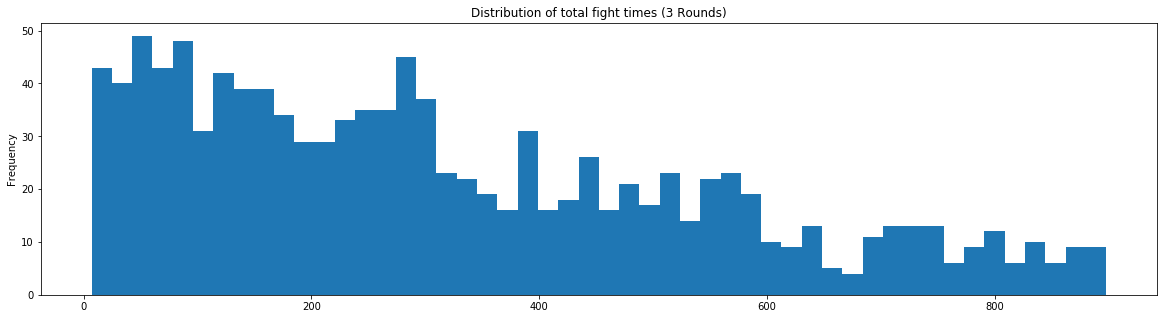

In [11]:
surv_df_3[surv_df_3['KO']]['fight_time'].plot(kind = 'hist', figsize = [20,5], bins = 50, 
                                              title = "Distribution of total fight times (3 Rounds)")
print surv_df_3[surv_df_3['KO']]['fight_time'].describe()

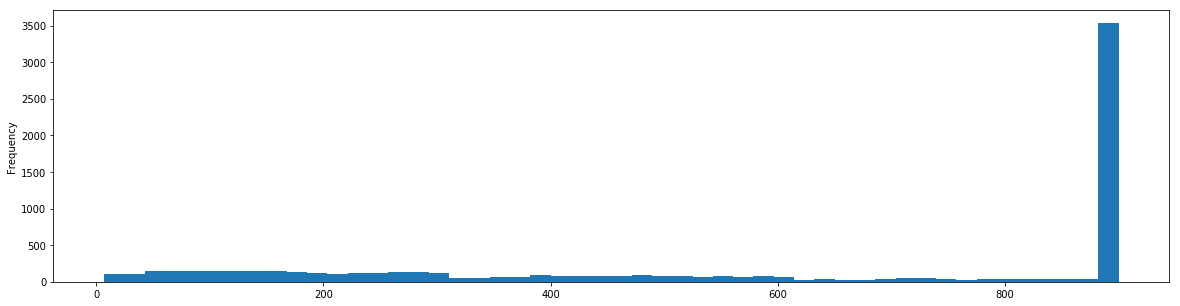

In [12]:
surv_df_3['fight_time'].plot(kind = 'hist', figsize = [20,5], bins = 50)

Now, we use the `KaplanMeierFitter` function from lifelines in order to estimate the survival function

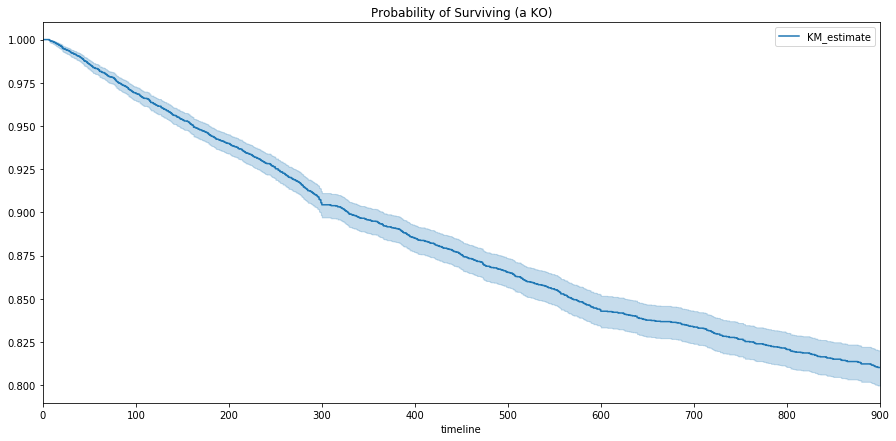

In [13]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(surv_df_3['fight_time'], event_observed=surv_df_3['KO'])
kmf.plot(title = "Probability of Surviving (a KO)", figsize = [15,7])

Interpretation of the curve is pretty straightforward. Each point represents the probabilty of surviving up to that point. 

For example, there's a ~82% chance of not getting KO'd within the first round, and ~70% chance of not getting KO'd within the first 2 rounds. Ultimately, it looks like theres a 65% chance of not getting KO'd at all, for a 3 round fight.


Much survival analysis involves modelling the hazard function h(t), defined as the instantaneous probability that the event occurs at time t. For this analysis, h(t) is the probability of getting knocked at in the time [t, t+d], where d is really (really) small.

We can approximate the hazard function by taking the ratio of survival probability at time t against time t-1, which the probability of surving till t given surviving up to t-1, and subtracting that from one.

/Users/stephenma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


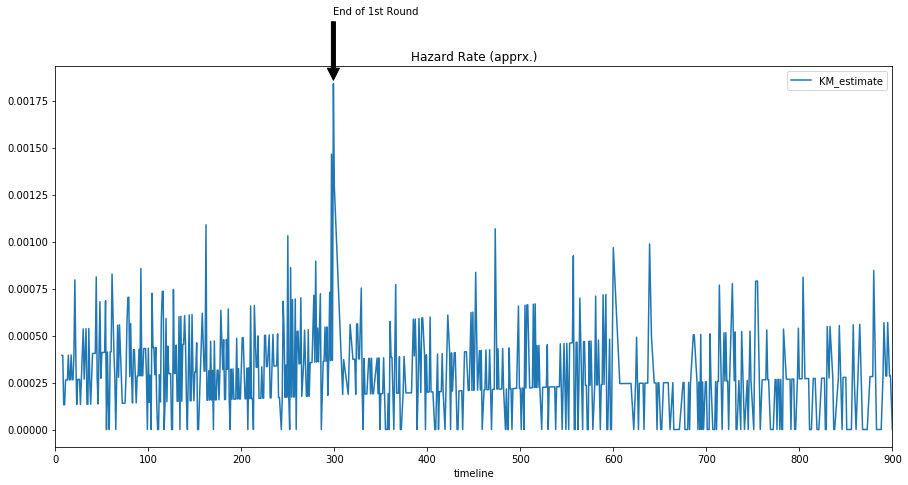

In [14]:
hazard = (1 - kmf.survival_function_/kmf.survival_function_. shift(1))
ax = hazard.plot(title = "Hazard Rate (apprx.)",figsize = [15,7])

_ = ax.annotate('End of 1st Round', xy=(299, hazard.ix[299]), xytext=(299, hazard.ix[299]*1.2),
            arrowprops=dict(facecolor='black', shrink=0.05))


It's not pretty, but one thing that's cool is the jump at 300. Looks like in the few seconds before the first round ends, the probability of getting knocked out jumps by 2X. 

Conspiracy theories aside, we can try using other variables as our time variable. Let's try with `head_strikes`, since those are the things that should directly lead to KO's.

In [15]:
len(surv_df_3[surv_df_3['head_strikes']>= 50])

555

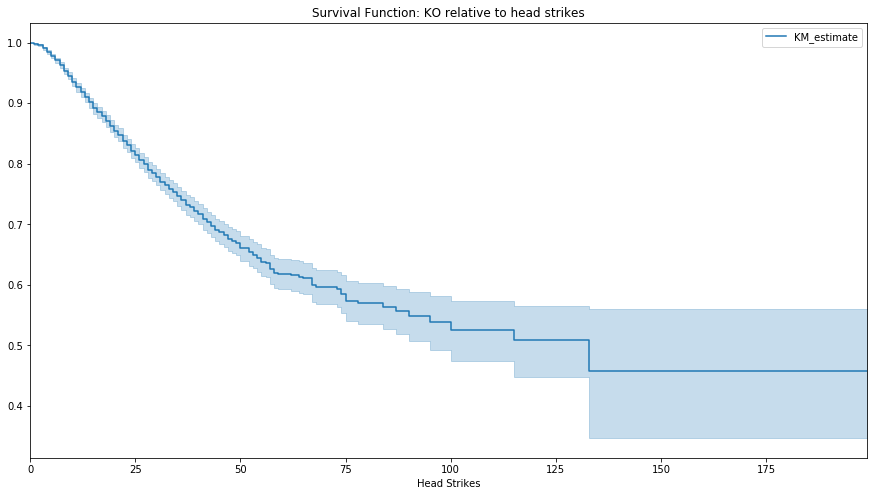

In [19]:
# surv_df_3[surv_df_3['KO']]['head_strikes'].plot(kind = 'hist', figsize = [20,5], bins = 50,
#                                                title = "Distribution of Head Strikes")
# plt.show()

kmf.fit(surv_df_3['head_strikes'], event_observed=surv_df_3['KO'])
# fig, axes = plt.subplots(2,1, figsize = [15,12])

ax = kmf.plot( title = "Survival Function: KO relative to head strikes", figsize = (15,8))
_  = ax.set_xlabel("Head Strikes")

# hazard = (1 - kmf.survival_function_/kmf.survival_function_. shift(1))
# ax = hazard.plot(ax = axes[1], title = "Hazard Rate (apprx.)")
# _ = ax.set_xlabel("Head Strikes")

Interestingly enough, past 50 head strikes, the survival curve starts to plateau. I'm guessing there's a few factors at play such as:
- after a certain point, there's a diminishing marginal power for each additional strike, due to fatigue
- there are some fighters who are excellent strikers, but don't have "knockout" power -- we're probably seeing a lot of these guys in the high head strike volume range

We can also calcualte the survival function based on number of strikes on other body parts (namely the body and leg). Let's plot them on top of each other to compare effectiveness.

/Users/stephenma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/stephenma/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


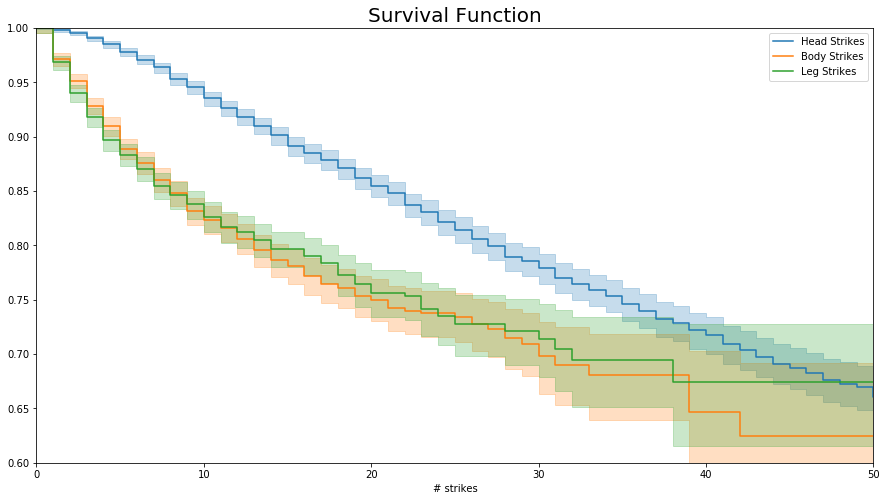

In [35]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
kmf.fit(surv_df_3['head_strikes'], event_observed=surv_df_3['KO'],label = "Head Strikes")
ax = kmf.plot(ax = ax)

kmf.fit(surv_df_3['body_strikes'], event_observed=surv_df_3['KO'], label = "Body Strikes")
kmf.confidence_interval_ = kmf.confidence_interval_  + float(1-kmf.survival_function_.ix[0])
kmf.survival_function_ = (1-kmf.survival_function_.ix[0]) + kmf.survival_function_
ax = kmf.plot(ax = ax)

kmf.fit(surv_df_3['leg_strikes'], event_observed=surv_df_3['KO'], label = "Leg Strikes")
kmf.confidence_interval_ = kmf.confidence_interval_  + float(1-kmf.survival_function_.ix[0])

kmf.survival_function_ = (1-kmf.survival_function_.ix[0]) + kmf.survival_function_
ax = kmf.plot(ax = ax)
_ = ax.set_xlim([0,50])
_ = ax.set_xlabel("# strikes")
_ = ax.set_ylim([.6,1])
_ = plt.title("Survival Function", fontsize = 20)

Body and leg strike more effective than head strikes


In [ ]:
surv_df_5[surv_df_5['KO']]['head_strikes'].plot(kind = 'hist', figsize = [20,5], bins = 50,
                                               title = "Distribution of Head Strikes")
plt.show()

kmf.fit(surv_df_5['head_strikes'], event_observed=surv_df_5['KO'])
fig, axes = plt.subplots(1,2, figsize = [20,8])

ax = kmf.plot(ax = axes[0], title = "Survival Function: KO as relative to head strikes")
_  = ax.set_xlabel("Head Strikes")

hazard = (1 - kmf.survival_function_/kmf.survival_function_. shift(1))
ax = hazard.plot(ax = axes[1], title = "Hazard Rate (apprx.)")
_ = ax.set_xlabel("Head Strikes")

In [ ]:
surv_df_3['bout'].value_counts().head(10)

In [ ]:
surv_df_3[surv_df_3['bout'] == "Women's Strawweight Bout"]['KO'].value_counts()

In [ ]:
fig = plt.figure(figsize = [20,10])
ax = subplot(111)
for k, bout in enumerate(surv_df_3['bout'].value_counts().head(10).index.tolist()):
    df = surv_df[surv_df['bout']==bout]
    
    kmf.fit(df['head_strikes'], event_observed=df['KO'], label = bout)
    kmf.survival_function_.plot(ax = ax)
ax.set_xlabel("Head Strikes")
plt.title("Survival Functions per Division", fontsize=20)
# surv_df_3['bout'].value_counts()